# Lab 3 - Uncertainty and Simple Climate Models
**Due**: Monday, 2/13 by 1:00pm.

Make sure you include your name and ID below for submission. <br>
**Name**:  <br>
**ID**:

## Contents

In [35]:
# load project environment
import Pkg # load the Pkg package manager
Pkg.activate(@__DIR__) # activate the environment in the directory of the script file
Pkg.instantiate() # make sure all of the needed packages are installed with correct versions

  Activating project at `~/Teaching/BEE6940/labs/lab03`


---

## Introduction

As we discussed in class, general circulation models (GCMs, or global climate models) are computationally expensive, and difficult to run many times. Simple climate models (SCMs) are a solution: they use simplified energy-balance and (sometimes) carbon-cycle dynamics and output aggregated measures such as global mean temperature and ocean heat content. Finer-scale climate dynamics, which require representations of atmospheric and ocean circulations and more complex thermodynamics, are usually neglected. But by virtue of their simplicity, SCMs can be used to emulate more complex models; they can be:
- run many more times;
- and can be forced with almost arbitrary emissions and/or radiative forcings.
This makes SCMs useful for uncertainty and risk analyses.

### Running SNEASY

In this exercise, you will load and run SNEASY, a Simple Nonlinear EArth SYstem model ([Urban and Keller (2010)](https://dx.doi.org/10.1111/j.1600-0870.2010.00471.x)). We won't get into the details of SNEASY, but it includes the following modules:
- Climate (DOECLIM), which is an energy-balance model of the atmosphere and a 1-dimensional ocean model;
- Carbon-cycle, which models terrestrial and oceanic carbon sinks and sources in aggregate;
- A box model of the Atlantic meridional overturning circculation (AMOC), which we will ignore.

We will use the [`Mimi` framework](https://www.mimiframework.org/) for integrated assessment modeling in Julia, which includes a version of SNEASY for use with these models. `MimiSNEASY.jl` is included in your lab project environment.

First, let's load `MimiSNEASY.jl` and set some default parameters. SNEASY has around 10 parameters, but here we're going to focus on equilibrium climate sensitivity (`t2co`), ocean heat diffusivity (`kappa`), aerosol scaling (`alpha`), and carbon respiration temperature sensitivity (`Q10`). We'll set all of the parameters to default values corresponding to the best model fit (more on this in a few weeks), and then update them as needed.

The Mimi API can be a little involved, so we've provided you with several functions (in `src/sneasy_model_functions.jl`) which simplify things for the purpose of this lab. Feel free to look through this file and ask any questions about syntax!
These functions are:
- `create_sneasy_model(; rcp_scenario="RCP85", start_year=1765, end_year=2100)`: create a MimiSNEASY model instance corresponding to a particular RCP.
- `set_sneasy_params!(m, params, parnames)`: change parameters in a MimiSNEASY model `m` based on a value vector `params` and a name vector `parnames`, which should match.
- `query_temperature(m, model_years, query_years)`: query global mean temperature anomalies, relative to the 1861-1880 mean.

Note the exclamation mark at the end of the `set_sneasy_params!() function`: this indicates that it modifies the input in-place instead of creating a new object. This is standard Julia naming convention.

In [36]:
# load the Mimi.jl base package and the MimiSNEASY model, as well as CSVFiles.jl (to read .csv files) and DataFrames.jl (to work with tabular data). Also load Plots.jl for plotting later.
using Mimi
using MimiSNEASY
using CSVFiles
using DataFrames
using Plots

include("src/sneasy_model_functions.jl") # load helper functions
# set up array of model years; this aligns with defaults, but we'll want to use this to query and normalize later
start_year = 1765
end_year = 2100
model_years = collect(start_year:end_year);

Let's create the model object. For now, we'll just use RCP 8.5.

In [37]:
m = create_sneasy_model(rcp_scenario="RCP85", start_year=start_year, end_year=end_year)

Mimi.Model
  Module: Mimi
  Components:
    ComponentId(MimiSNEASY.rfco2)
    ComponentId(MimiSNEASY.radiativeforcing)
    ComponentId(MimiSNEASY.doeclim)
    ComponentId(MimiSNEASY.ccm)
  Built: false


The default parameters in MimiSNEASY are not useful; they're just defaults, but won't let us get a sensible output. Next, we will use `set_sneasy_params!()` to set best-fit parameter values. We'll discuss what we mean by "best fit" in the next part of the class.

Load the parameter set using `load()` from `CSVFiles.jl`. We'll also convert this to a `DataFrame` object, which is a nice package for working with tabular data (more on `DataFrame` in a subsequent exercise). This parameter set came from calibration of SNEASY and an ice-sheet model, so there are a lot more parameters than we need, but the `set_sneasy_params!()`` function takes care of that.

In [38]:
parameters = DataFrame(load(joinpath(@__DIR__, "params","parameters_subsample_sneasybrick.csv")));

The best-fit parameter vector is row 6340, so let's set the parameters to that value.

In [39]:
set_sneasy_params!(m, parameters[6340, :], names(parameters))

Run the model:

In [40]:
run(m)

Finally, let's query and plot temperatures from 1850 to 2100.

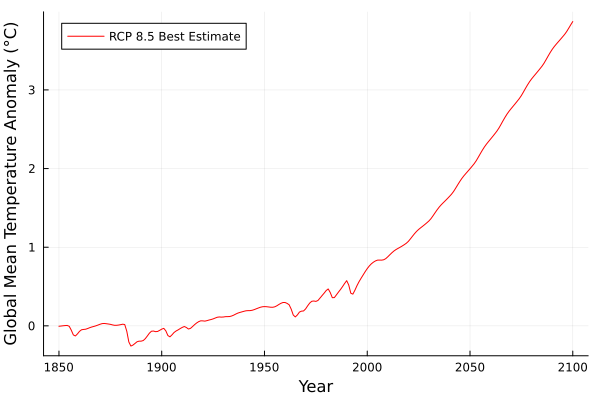

In [46]:
query_years = 1850:2100
temps = query_temperature(m, model_years, query_years)
plot(query_years, temps, color=:red, label="RCP 8.5 Best Estimate") 
xlabel!("Year")
ylabel!("Global Mean Temperature Anomaly (°C)")

### Uncertainty Analysis

Let's now look at how to generate and plot uncertainty intervals. We'll subsample 1,000 parameter combinations from the parameter set, run the model over that sample, and then plot the central 95% interval each year on top of the "best estimate" line above. 

In [42]:
# load StatsBase package to sample with replacement
using StatsBase
using Random

Random.seed!(1)

n_sample = 1000
# get subsample
sample_index = sample(1:nrow(parameters), n_sample, replace=true)
param_sample = parameters[sample_index, :]


In [ ]:

# set up storage for temperatures
temps = zeros(n_sample, length(query_years))

# loop over parameters and get temperatures
for i = 1:n_sample
    set_sneasy_params!(m, parameters[i, :], names(parameters))
    run(m)
    temps[i, :] = query_temperature(m, model_years, query_years)
end



In [43]:
# get central 95% interval for each year by picking the 2.5% and 97.5% quantiles
temp_quantiles = mapslices(x -> quantile(x, [0.025, 0.975]), temps, dims=1)

2×251 Matrix{Float64}:
 -0.0178938    -0.0134301   …  3.18734  3.2252   3.26331  3.29973
 -0.000688753   0.00241029     4.95955  5.02171  5.08551  5.14774

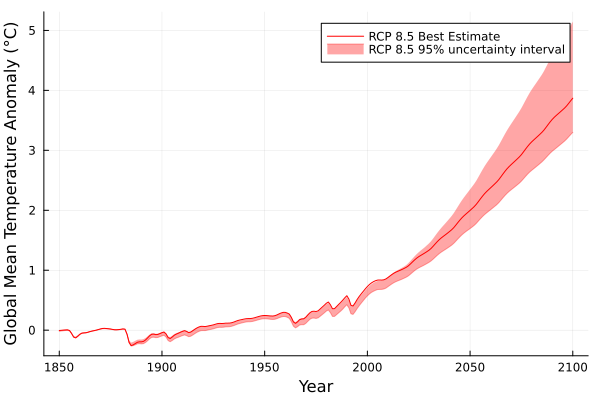

In [47]:
plot!(query_years, temp_quantiles[1, :], fillrange=temp_quantiles[2, :], fillalpha=0.35, alpha =0.35, color=:red, label="RCP 8.5 95% uncertainty interval")

## Exercises
Complete the following exercises. Convert your completed notebook to a PDF and submit it to the Gradescope Assignment "Lab 3".

Remember to evaluate all of your code cells, in order (using a Run All command). This will make sure all output is visible and that the code cells were evaluated in the correct order.

### Exercise 1: Scenario and Parametric Uncertainty

#### Exercise 1.1 (10 points)

Plot SNEASY global mean temperatures corresponding to the best fit parameter set for each of the RCPs (2.6, 4.5, 6.0, and 8.5). I recommend making a new model instance for each RCP, which you'll reuse in Exercise 1.2.


#### Exercise 1.2 (15 points)

Calculate the 95% uncertainty intervals for each RCP using the parameter subsample above. Plot these on the same graph as the best estimates.

### Exercise 2: Neglecting Correlations

#### Exercise 2.1 (10 points)

Set SNEASY model parameters to the best fit. Draw 1,000 independent sampled parameter values for climate sensitivity and ocean heat diffusivity. These are columns 29 and 27 in the `parameters` DataFrame, respectively (found using `indexin(["climate_sensitivity", "heat_diffusivity"], names(parameters))`). 


In [48]:
parameters[:, [29, 27]]

Row,climate_sensitivity,heat_diffusivity
,Float64,Float64
1,3.56475,2.49072
2,1.89759,1.81077
3,4.07412,5.47466
4,4.56024,4.17145
5,2.98581,2.82943
6,3.73207,4.19397
7,2.24015,1.39779
8,2.20063,2.15308
9,3.19311,3.407



Make a scatterplot of the independent samples (using `scatter()`) and, in a different color (but on the same plot), plot the correlated samples from the `parameters` DataFrame.

#### Exercise 2.2 (15 points)

Run SNEASY for RCP 8.5 with your independent samples. You can use `set_sneasy_params!()` as before with the `parnames` vector `["climate_sensitivity", "heat_diffusivity"]`. Plot the resulting 95% interval along with the previous 95% RCP 8.5 interval which used the correlated parameter set.

## References

Give credit to any consulted references here, whether they were your classmates, online resources, or anything else.